# Pixel 2 Mesh Sandbox

In [43]:
# https://arxiv.org/pdf/1804.01654v2
# p2m model init needs camera focal length, camera center and mesh center



In [44]:
import math

import torch
import torch.nn as nn

def batch_mm(matrix, batch):
    """
    https://github.com/pytorch/pytorch/issues/14489
    """
    # TODO: accelerate this with batch operations
    return torch.stack([matrix.mm(b) for b in batch], dim=0)


def dot(x, y, sparse=False):
    """Wrapper for torch.matmul (sparse vs dense)."""
    if sparse:
        return batch_mm(x, y)
    else:
        return torch.matmul(x, y)

class GConv(nn.Module):
    """Simple GCN layer

    Similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, adj_mat, bias=True):
        super(GConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.adj_mat = nn.Parameter(adj_mat, requires_grad=False)
        self.weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        # Following https://github.com/Tong-ZHAO/Pixel2Mesh-Pytorch/blob/a0ae88c4a42eef6f8f253417b97df978db842708/model/gcn_layers.py#L45
        # This seems to be different from the original implementation of P2M
        self.loop_weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        if bias:
            self.bias = nn.Parameter(torch.zeros((out_features,), dtype=torch.float))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight.data)
        nn.init.xavier_uniform_(self.loop_weight.data)

    def forward(self, inputs):
        support = torch.matmul(inputs, self.weight)
        support_loop = torch.matmul(inputs, self.loop_weight)
        output = dot(self.adj_mat, support, True) + support_loop
        if self.bias is not None:
            ret = output + self.bias
        else:
            ret = output
        return ret

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class GConv(nn.Module):
    """Simple GCN layer

    Similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, adj_mat, bias=True):
        super(GConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.adj_mat = nn.Parameter(adj_mat, requires_grad=False)
        self.weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        # Following https://github.com/Tong-ZHAO/Pixel2Mesh-Pytorch/blob/a0ae88c4a42eef6f8f253417b97df978db842708/model/gcn_layers.py#L45
        # This seems to be different from the original implementation of P2M
        self.loop_weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        if bias:
            self.bias = nn.Parameter(torch.zeros((out_features,), dtype=torch.float))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight.data)
        nn.init.xavier_uniform_(self.loop_weight.data)

    def forward(self, inputs):
        support = torch.matmul(inputs, self.weight)
        support_loop = torch.matmul(inputs, self.loop_weight)
        output = dot(self.adj_mat, support, True) + support_loop
        if self.bias is not None:
            ret = output + self.bias
        else:
            ret = output
        return ret

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GResBlock(nn.Module):

    def __init__(self, in_dim, hidden_dim, adj_mat, activation=None):
        super(GResBlock, self).__init__()

        self.conv1 = GConv(in_features=in_dim, out_features=hidden_dim, adj_mat=adj_mat)
        self.conv2 = GConv(in_features=hidden_dim, out_features=in_dim, adj_mat=adj_mat)
        self.activation = F.relu if activation else None

    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.activation:
            x = self.activation(x)
        x = self.conv2(x)
        if self.activation:
            x = self.activation(x)

        return (inputs + x) * 0.5


class GBottleneck(nn.Module):

    def __init__(self, block_num, in_dim, hidden_dim, out_dim, adj_mat, activation=None):
        super(GBottleneck, self).__init__()

        resblock_layers = [GResBlock(in_dim=hidden_dim, hidden_dim=hidden_dim, adj_mat=adj_mat, activation=activation)
                           for _ in range(block_num)]
        self.blocks = nn.Sequential(*resblock_layers)
        self.conv1 = GConv(in_features=in_dim, out_features=hidden_dim, adj_mat=adj_mat)
        self.conv2 = GConv(in_features=hidden_dim, out_features=out_dim, adj_mat=adj_mat)
        self.activation = F.relu if activation else None

    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.activation:
            x = self.activation(x)
        x_hidden = self.blocks(x)
        x_out = self.conv2(x_hidden)

        return x_out, x_hidden

In [46]:
import torch
from torchvision.models import ResNet
from torchvision.models.resnet import Bottleneck

PRETRAINED_WEIGHTS_PATH = 'path/to/pretrained/weights'

class P2MResNet(ResNet):

    def __init__(self, *args, **kwargs):
        self.output_dim = 0
        super().__init__(*args, **kwargs)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        res = super()._make_layer(block, planes, blocks, stride=stride, dilate=dilate)
        self.output_dim += self.inplanes
        return res

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        features = []
        x = self.layer1(x)
        features.append(x)
        x = self.layer2(x)
        features.append(x)
        x = self.layer3(x)
        features.append(x)
        x = self.layer4(x)
        features.append(x)

        return features

    @property
    def features_dim(self):
        return self.output_dim


def resnet50():
    model = P2MResNet(Bottleneck, [3, 4, 6, 3])
    state_dict = torch.load(PRETRAINED_WEIGHTS_PATH)
    model.load_state_dict(state_dict)
    return model

In [47]:
class VGG16TensorflowAlign(nn.Module):

    def __init__(self, n_classes_input=3):
        super(VGG16TensorflowAlign, self).__init__()

        self.features_dim = 960
        # this is to align with tensorflow padding (with stride)
        # https://bugxch.github.io/tf%E4%B8%AD%E7%9A%84padding%E6%96%B9%E5%BC%8FSAME%E5%92%8CVALID%E6%9C%89%E4%BB%80%E4%B9%88%E5%8C%BA%E5%88%AB/
        self.same_padding = nn.ZeroPad2d(1)
        self.tf_padding = nn.ZeroPad2d((0, 1, 0, 1))
        self.tf_padding_2 = nn.ZeroPad2d((1, 2, 1, 2))

        self.conv0_1 = nn.Conv2d(n_classes_input, 16, 3, stride=1, padding=0)
        self.conv0_2 = nn.Conv2d(16, 16, 3, stride=1, padding=0)

        self.conv1_1 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  # 224 -> 112
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=0)

        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=2, padding=0)  # 112 -> 56
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)

        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=2, padding=0)  # 56 -> 28
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=0)

        self.conv4_1 = nn.Conv2d(128, 256, 5, stride=2, padding=0)  # 28 -> 14
        self.conv4_2 = nn.Conv2d(256, 256, 3, stride=1, padding=0)
        self.conv4_3 = nn.Conv2d(256, 256, 3, stride=1, padding=0)

        self.conv5_1 = nn.Conv2d(256, 512, 5, stride=2, padding=0)  # 14 -> 7
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=0)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=0)
        self.conv5_4 = nn.Conv2d(512, 512, 3, stride=1, padding=0)

    def forward(self, img):
        img = F.relu(self.conv0_1(self.same_padding(img)))
        img = F.relu(self.conv0_2(self.same_padding(img)))

        img = F.relu(self.conv1_1(self.tf_padding(img)))
        img = F.relu(self.conv1_2(self.same_padding(img)))
        img = F.relu(self.conv1_3(self.same_padding(img)))

        img = F.relu(self.conv2_1(self.tf_padding(img)))
        img = F.relu(self.conv2_2(self.same_padding(img)))
        img = F.relu(self.conv2_3(self.same_padding(img)))
        img2 = img

        img = F.relu(self.conv3_1(self.tf_padding(img)))
        img = F.relu(self.conv3_2(self.same_padding(img)))
        img = F.relu(self.conv3_3(self.same_padding(img)))
        img3 = img

        img = F.relu(self.conv4_1(self.tf_padding_2(img)))
        img = F.relu(self.conv4_2(self.same_padding(img)))
        img = F.relu(self.conv4_3(self.same_padding(img)))
        img4 = img

        img = F.relu(self.conv5_1(self.tf_padding_2(img)))
        img = F.relu(self.conv5_2(self.same_padding(img)))
        img = F.relu(self.conv5_3(self.same_padding(img)))
        img = F.relu(self.conv5_4(self.same_padding(img)))
        img5 = img

        return [img2, img3, img4, img5]


class VGG16P2M(nn.Module):

    def __init__(self, n_classes_input=3, pretrained=False):
        super(VGG16P2M, self).__init__()

        self.features_dim = 960

        self.conv0_1 = nn.Conv2d(n_classes_input, 16, 3, stride=1, padding=1)
        self.conv0_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.conv1_1 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # 224 -> 112
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 112 -> 56
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 56 -> 28
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(128, 256, 5, stride=2, padding=2)  # 28 -> 14
        self.conv4_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(256, 512, 5, stride=2, padding=2)  # 14 -> 7
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, 3, stride=1, padding=1)

        if "vgg16p2m" in PRETRAINED_WEIGHTS_PATH and pretrained:
            state_dict = torch.load(PRETRAINED_WEIGHTS_PATH)
            self.load_state_dict(state_dict)
        else:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, img):
        img = F.relu(self.conv0_1(img))
        img = F.relu(self.conv0_2(img))
        # img0 = torch.squeeze(img) # 224

        img = F.relu(self.conv1_1(img))
        img = F.relu(self.conv1_2(img))
        img = F.relu(self.conv1_3(img))
        # img1 = torch.squeeze(img) # 112

        img = F.relu(self.conv2_1(img))
        img = F.relu(self.conv2_2(img))
        img = F.relu(self.conv2_3(img))
        img2 = img

        img = F.relu(self.conv3_1(img))
        img = F.relu(self.conv3_2(img))
        img = F.relu(self.conv3_3(img))
        img3 = img

        img = F.relu(self.conv4_1(img))
        img = F.relu(self.conv4_2(img))
        img = F.relu(self.conv4_3(img))
        img4 = img

        img = F.relu(self.conv5_1(img))
        img = F.relu(self.conv5_2(img))
        img = F.relu(self.conv5_3(img))
        img = F.relu(self.conv5_4(img))
        img5 = img

        return [img2, img3, img4, img5]


class VGG16Recons(nn.Module):

    def __init__(self, input_dim=512, image_channel=3):
        super(VGG16Recons, self).__init__()

        self.conv_1 = nn.ConvTranspose2d(input_dim, 256, kernel_size=2, stride=2, padding=0)  # 7 -> 14
        self.conv_2 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)  # 14 -> 28
        self.conv_3 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)  # 28 -> 56
        self.conv_4 = nn.ConvTranspose2d(128, 32, kernel_size=6, stride=2, padding=2)  # 56 -> 112
        self.conv_5 = nn.ConvTranspose2d(32, image_channel, kernel_size=6, stride=2, padding=2)  # 112 -> 224

    def forward(self, img_feats):
        x = F.relu(self.conv_1(img_feats[-1]))
        x = torch.cat((x, img_feats[-2]), dim=1)
        x = F.relu(self.conv_2(x))
        x = torch.cat((x, img_feats[-3]), dim=1)
        x = F.relu(self.conv_3(x))
        x = torch.cat((x, img_feats[-4]), dim=1)
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_5(x))

        return torch.sigmoid(x)

In [48]:
def get_backbone(options):
    if options.backbone.startswith("vgg16"):
        if options.align_with_tensorflow:
            nn_encoder = VGG16TensorflowAlign()
        else:
            nn_encoder = VGG16P2M(pretrained="pretrained" in options.backbone)
        nn_decoder = VGG16Recons()
    elif options.backbone == "resnet50":
        nn_encoder = resnet50()
        nn_decoder = None
    else:
        raise NotImplementedError("No implemented backbone called '%s' found" % options.backbone)
    return nn_encoder, nn_decoder

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GUnpooling(nn.Module):
    """Graph Pooling layer, aims to add additional vertices to the graph.
    The middle point of each edges are added, and its feature is simply
    the average of the two edge vertices.
    Three middle points are connected in each triangle.
    """

    def __init__(self, unpool_idx):
        super(GUnpooling, self).__init__()
        self.unpool_idx = unpool_idx
        # save dim info
        self.in_num = torch.max(unpool_idx).item()
        self.out_num = self.in_num + len(unpool_idx)

    def forward(self, inputs):
        new_features = inputs[:, self.unpool_idx].clone()
        new_vertices = 0.5 * new_features.sum(2)
        output = torch.cat([inputs, new_vertices], 1)

        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_num) + ' -> ' \
               + str(self.out_num) + ')'

import numpy as np
from torch.nn import Threshold

class GProjection(nn.Module):
    """
    Graph Projection layer, which pool 2D features to mesh

    The layer projects a vertex of the mesh to the 2D image and use
    bi-linear interpolation to get the corresponding feature.
    """

    def __init__(self, mesh_pos, camera_f, camera_c, bound=0, tensorflow_compatible=False):
        super(GProjection, self).__init__()
        self.mesh_pos, self.camera_f, self.camera_c = mesh_pos, camera_f, camera_c
        self.threshold = None
        self.bound = 0
        self.tensorflow_compatible = tensorflow_compatible
        if self.bound != 0:
            self.threshold = Threshold(bound, bound)

    def bound_val(self, x):
        """
        given x, return min(threshold, x), in case threshold is not None
        """
        if self.bound < 0:
            return -self.threshold(-x)
        elif self.bound > 0:
            return self.threshold(x)
        return x

    @staticmethod
    def image_feature_shape(img):
        return np.array([img.size(-1), img.size(-2)])

    def project_tensorflow(self, x, y, img_size, img_feat):
        x = torch.clamp(x, min=0, max=img_size[1] - 1)
        y = torch.clamp(y, min=0, max=img_size[0] - 1)

        # it's tedious and contains bugs...
        # when x1 = x2, the area is 0, therefore it won't be processed
        # keep it here to align with tensorflow version
        x1, x2 = torch.floor(x).long(), torch.ceil(x).long()
        y1, y2 = torch.floor(y).long(), torch.ceil(y).long()

        Q11 = img_feat[:, x1, y1].clone()
        Q12 = img_feat[:, x1, y2].clone()
        Q21 = img_feat[:, x2, y1].clone()
        Q22 = img_feat[:, x2, y2].clone()

        weights = torch.mul(x2.float() - x, y2.float() - y)
        Q11 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q11, 0, 1))

        weights = torch.mul(x2.float() - x, y - y1.float())
        Q12 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q12, 0, 1))

        weights = torch.mul(x - x1.float(), y2.float() - y)
        Q21 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q21, 0, 1))

        weights = torch.mul(x - x1.float(), y - y1.float())
        Q22 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q22, 0, 1))

        output = Q11 + Q21 + Q12 + Q22
        return output

    def forward(self, resolution, img_features, inputs):
        half_resolution = (resolution - 1) / 2
        camera_c_offset = np.array(self.camera_c) - half_resolution
        # map to [-1, 1]
        # not sure why they render to negative x
        positions = inputs + torch.tensor(self.mesh_pos, device=inputs.device, dtype=torch.float)
        w = -self.camera_f[0] * (positions[:, :, 0] / self.bound_val(positions[:, :, 2])) + camera_c_offset[0]
        h = self.camera_f[1] * (positions[:, :, 1] / self.bound_val(positions[:, :, 2])) + camera_c_offset[1]

        if self.tensorflow_compatible:
            # to align with tensorflow
            # this is incorrect, I believe
            w += half_resolution[0]
            h += half_resolution[1]

        else:
            # directly do clamping
            w /= half_resolution[0]
            h /= half_resolution[1]

            # clamp to [-1, 1]
            w = torch.clamp(w, min=-1, max=1)
            h = torch.clamp(h, min=-1, max=1)

        feats = [inputs]
        for img_feature in img_features:
            feats.append(self.project(resolution, img_feature, torch.stack([w, h], dim=-1)))

        output = torch.cat(feats, 2)

        return output

    def project(self, img_shape, img_feat, sample_points):
        """
        :param img_shape: raw image shape
        :param img_feat: [batch_size x channel x h x w]
        :param sample_points: [batch_size x num_points x 2], in range [-1, 1]
        :return: [batch_size x num_points x feat_dim]
        """
        if self.tensorflow_compatible:
            feature_shape = self.image_feature_shape(img_feat)
            points_w = sample_points[:, :, 0] / (img_shape[0] / feature_shape[0])
            points_h = sample_points[:, :, 1] / (img_shape[1] / feature_shape[1])
            output = torch.stack([self.project_tensorflow(points_h[i], points_w[i],
                                                          feature_shape, img_feat[i]) for i in range(img_feat.size(0))], 0)
        else:
            output = F.grid_sample(img_feat, sample_points.unsqueeze(1))
            output = torch.transpose(output.squeeze(2), 1, 2)

        return output

class P2MModel(nn.Module):

    def __init__(self, options, ellipsoid, camera_f, camera_c, mesh_pos):
        super(P2MModel, self).__init__()

        self.hidden_dim = options.hidden_dim
        self.coord_dim = options.coord_dim
        self.last_hidden_dim = options.last_hidden_dim
        self.init_pts = nn.Parameter(ellipsoid.coord, requires_grad=False)
        self.gconv_activation = options.gconv_activation

        self.nn_encoder, self.nn_decoder = get_backbone(options)
        self.features_dim = self.nn_encoder.features_dim + self.coord_dim

        self.gcns = nn.ModuleList([
            GBottleneck(6, self.features_dim, self.hidden_dim, self.coord_dim,
                        ellipsoid.adj_mat[0], activation=self.gconv_activation),
            GBottleneck(6, self.features_dim + self.hidden_dim, self.hidden_dim, self.coord_dim,
                        ellipsoid.adj_mat[1], activation=self.gconv_activation),
            GBottleneck(6, self.features_dim + self.hidden_dim, self.hidden_dim, self.last_hidden_dim,
                        ellipsoid.adj_mat[2], activation=self.gconv_activation)
        ])

        self.unpooling = nn.ModuleList([
            GUnpooling(ellipsoid.unpool_idx[0]),
            GUnpooling(ellipsoid.unpool_idx[1])
        ])

        # if options.align_with_tensorflow:
        #     self.projection = GProjection
        # else:
        #     self.projection = GProjection
        self.projection = GProjection(mesh_pos, camera_f, camera_c, bound=options.z_threshold,
                                      tensorflow_compatible=options.align_with_tensorflow)

        self.gconv = GConv(in_features=self.last_hidden_dim, out_features=self.coord_dim,
                           adj_mat=ellipsoid.adj_mat[2])

    def forward(self, img):
        batch_size = img.size(0)
        img_feats = self.nn_encoder(img)
        img_shape = self.projection.image_feature_shape(img)

        init_pts = self.init_pts.data.unsqueeze(0).expand(batch_size, -1, -1)
        # GCN Block 1
        x = self.projection(img_shape, img_feats, init_pts)
        x1, x_hidden = self.gcns[0](x)

        # before deformation 2
        x1_up = self.unpooling[0](x1)

        # GCN Block 2
        x = self.projection(img_shape, img_feats, x1)
        x = self.unpooling[0](torch.cat([x, x_hidden], 2))
        # after deformation 2
        x2, x_hidden = self.gcns[1](x)

        # before deformation 3
        x2_up = self.unpooling[1](x2)

        # GCN Block 3
        x = self.projection(img_shape, img_feats, x2)
        x = self.unpooling[1](torch.cat([x, x_hidden], 2))
        x3, _ = self.gcns[2](x)
        if self.gconv_activation:
            x3 = F.relu(x3)
        # after deformation 3
        x3 = self.gconv(x3)

        if self.nn_decoder is not None:
            reconst = self.nn_decoder(img_feats)
        else:
            reconst = None

        return {
            "pred_coord": [x1, x2, x3],
            "pred_coord_before_deform": [init_pts, x1_up, x2_up],
            "reconst": reconst
        }

In [50]:
import torch
import numpy as np
import trimesh
from typing import List, Tuple

def _unique_edges(faces: np.ndarray) -> np.ndarray:
    # faces: (F,3)
    e01 = faces[:, [0, 1]]
    e12 = faces[:, [1, 2]]
    e20 = faces[:, [2, 0]]
    all_e = np.vstack([e01, e12, e20])
    all_e.sort(axis=1)   # undirected
    return np.unique(all_e, axis=0)

class Ellipsoid:
    def __init__(
        self,
        a: float = 1.0,
        b: float = 1.0,
        c: float = 1.0,
        base_subdivisions: int = 3,
        lap_k: int = 10,
    ):
        """
        Builds three levels of icosphere meshes (subdivisions = base_subdivisions,
        +1 and +2), scales them by (a,b,c), and then:
          - coord           : (V0, 3)  coarse vertices
          - faces[i]        : (Fi,3)   triangle indices at level i
          - edges[i]        : (Ei,2)   unique undirected edges at level i
          - laplace_idx[i]  : (Vi, lap_k) neighbor indices padded with -1
          - adj_mat[i]      : sparse COO (Vi × Vi)
          - unpool_idx      : [edges_coarse, edges_mid]
        """
        # 1) create & scale meshes
        meshes = []
        for s in [base_subdivisions, base_subdivisions + 1, base_subdivisions + 2]:
            m = trimesh.creation.icosphere(subdivisions=s, radius=1.0)
            m.apply_scale([a, b, c])
            meshes.append(m)

        # 2) extract verts & faces as torch
        verts: List[torch.Tensor] = [
            torch.from_numpy(m.vertices).float() for m in meshes
        ]
        faces: List[torch.Tensor] = [
            torch.from_numpy(m.faces.astype(np.int64)).long() for m in meshes
        ]
        self.coord = verts[0]   # coarse points for init_pts
        self.faces = faces      # three levels

        self.edges: List[torch.Tensor] = []
        self.laplace_idx: List[torch.Tensor] = []
        self.adj_mat: List[torch.sparse_coo_tensor] = []

        # 3) for each level build edges, laplacian‐index, adj_mat
        for i, (v, f) in enumerate(zip(verts, faces)):
            V = v.shape[0]

            # 3a) edges
            ue = _unique_edges(f.numpy())            # (Ei,2) as np
            e_t = torch.from_numpy(ue).long()         # to torch
            self.edges.append(e_t)

            # 3b) laplace_idx (k-NN padding)
            nbrs = [[] for _ in range(V)]
            for u, w in ue:
                nbrs[u].append(int(w))
                nbrs[w].append(int(u))

            L = torch.full((V, lap_k), -1, dtype=torch.long)
            for vidx in range(V):
                picks = nbrs[vidx][:lap_k]
                if picks:
                    L[vidx, : len(picks)] = torch.tensor(picks, dtype=torch.long)
            self.laplace_idx.append(L)

            # 3c) adjacency sparse COO
            rows = []
            cols = []
            for u, w in ue:
                rows += [u, w]
                cols += [w, u]
            idx = torch.tensor([rows, cols], dtype=torch.long)
            vals = torch.ones(idx.shape[1], dtype=torch.float)
            A = torch.sparse_coo_tensor(idx, vals, (V, V))
            self.adj_mat.append(A)

        # 4) unpool: coarse→mid and mid→fine
        #    simply “every edge spawns a midpoint”
        self.unpool_idx = [
            self.edges[0],   # shape (E0,2)
            self.edges[1],   # shape (E1,2)
        ]

    def __repr__(self):
        vs = [v.shape[0] for v in self.laplace_idx]
        es = [e.shape[0] for e in self.edges]
        fs = [f.shape[0] for f in self.faces]
        return (
            f"<Ellipsoid: "
            f"levels V={vs}, E={es}, F={fs}>"
        )


In [51]:
import pickle
import trimesh
import torch

ell = Ellipsoid(a=1.0, b=1.2, c=0.8, base_subdivisions=3)

In [52]:
import os
import pprint
from argparse import ArgumentParser
from datetime import datetime

import numpy as np
import yaml
from easydict import EasyDict as edict

options = edict()

options.name = 'p2m'
options.version = None
options.num_workers = 1
options.num_gpus = 1
options.pin_memory = True

options.log_dir = "logs"
options.log_level = "info"
options.summary_dir = "summary"
options.checkpoint_dir = "checkpoints"
options.checkpoint = None

options.dataset = edict()
options.dataset.name = "shapenet"
options.dataset.subset_train = "train_small"
options.dataset.subset_eval = "test_small"
options.dataset.camera_f = [248., 248.]
options.dataset.camera_c = [111.5, 111.5]
options.dataset.mesh_pos = [0., 0., -0.8]
options.dataset.normalization = True
options.dataset.num_classes = 13

options.dataset.shapenet = edict()
options.dataset.shapenet.num_points = 3000
options.dataset.shapenet.resize_with_constant_border = False

options.dataset.predict = edict()
options.dataset.predict.folder = "/tmp"

options.model = edict()
options.model.name = "pixel2mesh"
options.model.hidden_dim = 192
options.model.last_hidden_dim = 192
options.model.coord_dim = 3
options.model.backbone = "vgg16"
options.model.gconv_activation = True
# provide a boundary for z, so that z will never be equal to 0, on denominator
# if z is greater than 0, it will never be less than z;
# if z is less than 0, it will never be greater than z.
options.model.z_threshold = 0
# align with original tensorflow model
# please follow experiments/tensorflow.yml
options.model.align_with_tensorflow = False

options.loss = edict()
options.loss.weights = edict()
options.loss.weights.normal = 1.6e-4
options.loss.weights.edge = 0.3
options.loss.weights.laplace = 0.5
options.loss.weights.move = 0.1
options.loss.weights.constant = 1.
options.loss.weights.chamfer = [1., 1., 1.]
options.loss.weights.chamfer_opposite = 1.
options.loss.weights.reconst = 0.

options.train = edict()
options.train.num_epochs = 50
options.train.batch_size = 4
options.train.summary_steps = 50
options.train.checkpoint_steps = 10000
options.train.test_epochs = 1
options.train.use_augmentation = True
options.train.shuffle = True

options.test = edict()
options.test.dataset = []
options.test.summary_steps = 50
options.test.batch_size = 4
options.test.shuffle = False
options.test.weighted_mean = False

options.optim = edict()
options.optim.name = "adam"
options.optim.adam_beta1 = 0.9
options.optim.sgd_momentum = 0.9
options.optim.lr = 5.0E-5
options.optim.wd = 1.0E-6
options.optim.lr_step = [30, 45]
options.optim.lr_factor = 0.1

In [53]:
model = P2MModel(
    options=options.model,
    ellipsoid=ell,
    camera_f=torch.tensor([1.0,1.0]),
    camera_c=torch.tensor([112.0,112.0]),
    mesh_pos=torch.tensor([0,0,0])
)

In [54]:
out = model(torch.randn(1, 3, 224, 224))

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_19935/3713387980.py:97: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  camera_c_offset = np.array(self.camera_c) - half_resolution
/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_19935/3713387980.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positions = inputs + torch.tensor(self.mesh_pos, device=inputs.device, dtype=torch.float)
/Users/nils/Documents/Classes/bat/sequoia/.venv/lib/python3.11/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to

In [55]:
out.keys()

dict_keys(['pred_coord', 'pred_coord_before_deform', 'reconst'])

In [56]:
out['reconst'].shape

torch.Size([1, 3, 224, 224])

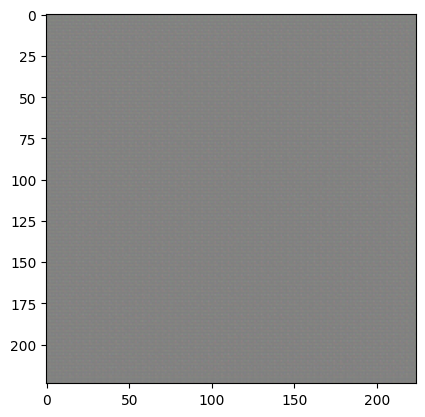

In [57]:
from matplotlib import pyplot as plt

# plot the out reconst
plt.imshow(out['reconst'][0].permute(1, 2, 0).detach().numpy())


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from chamferdist import ChamferDistance

class P2MLoss(nn.Module):
    def __init__(self, options, ellipsoid):
        super().__init__()
        self.options = options
        self.l1_loss = nn.L1Loss(reduction='mean')
        self.l2_loss = nn.MSELoss(reduction='mean')
        self.chamfer_dist = ChamferDistance()
        self.laplace_idx = nn.ParameterList([
            nn.Parameter(idx, requires_grad=False) for idx in ellipsoid.laplace_idx])
        self.edges = nn.ParameterList([
            nn.Parameter(edges, requires_grad=False) for edges in ellipsoid.edges])

    def edge_regularization(self, pred, edges):
        """
        :param pred: batch_size * num_points * 3
        :param edges: num_edges * 2
        :return:
        """
        return self.l2_loss(pred[:, edges[:, 0]], pred[:, edges[:, 1]]) * pred.size(-1)

    @staticmethod
    def laplace_coord(inputs, lap_idx):
        """
        :param inputs: nodes Tensor, size (n_pts, n_features = 3)
        :param lap_idx: laplace index matrix Tensor, size (n_pts, 10)
        for each vertex, the laplace vector shows: [neighbor_index * 8, self_index, neighbor_count]

        :returns
        The laplacian coordinates of input with respect to edges as in lap_idx
        """

        indices = lap_idx[:, :-2]
        invalid_mask = indices < 0
        all_valid_indices = indices.clone()
        all_valid_indices[invalid_mask] = 0  # do this to avoid negative indices

        vertices = inputs[:, all_valid_indices]
        vertices[:, invalid_mask] = 0
        neighbor_sum = torch.sum(vertices, 2)
        neighbor_count = lap_idx[:, -1].float()
        laplace = inputs - neighbor_sum / neighbor_count[None, :, None]

        return laplace

    def laplace_regularization(self, input1, input2, block_idx):
        """
        :param input1: vertices tensor before deformation
        :param input2: vertices after the deformation
        :param block_idx: idx to select laplace index matrix tensor
        :return:

        if different than 1 then adds a move loss as in the original TF code
        """

        lap1 = self.laplace_coord(input1, self.laplace_idx[block_idx])
        lap2 = self.laplace_coord(input2, self.laplace_idx[block_idx])
        laplace_loss = self.l2_loss(lap1, lap2) * lap1.size(-1)
        move_loss = self.l2_loss(input1, input2) * input1.size(-1) if block_idx > 0 else 0
        return laplace_loss, move_loss

    def normal_loss(self, gt_normal, indices, pred_points, adj_list):
        edges = F.normalize(pred_points[:, adj_list[:, 0]] - pred_points[:, adj_list[:, 1]], dim=2)
        nearest_normals = torch.stack([t[i] for t, i in zip(gt_normal, indices.long())])
        normals = F.normalize(nearest_normals[:, adj_list[:, 0]], dim=2)
        cosine = torch.abs(torch.sum(edges * normals, 2))
        return torch.mean(cosine)

    def image_loss(self, gt_img, pred_img):
        rect_loss = F.binary_cross_entropy(pred_img, gt_img)
        return rect_loss

    def forward(self, outputs, targets):
        """
        :param outputs: outputs from P2MModel
        :param targets: targets from input
        :return: loss, loss_summary (dict)
        """

        chamfer_loss, edge_loss, normal_loss, lap_loss, move_loss = 0., 0., 0., 0., 0.
        lap_const = [0.2, 1., 1.]

        gt_coord, gt_normal, gt_images = targets["points"], targets["normals"], targets["images"]
        pred_coord, pred_coord_before_deform = outputs["pred_coord"], outputs["pred_coord_before_deform"]
        image_loss = 0.
        if outputs["reconst"] is not None and self.options.weights.reconst != 0:
            image_loss = self.image_loss(gt_images, outputs["reconst"])

        for i in range(3):
            dist1, dist2, idx1, idx2 = self.chamfer_dist(gt_coord, pred_coord[i])
            chamfer_loss += self.options.weights.chamfer[i] * (torch.mean(dist1) +
                                                               self.options.weights.chamfer_opposite * torch.mean(dist2))
            normal_loss += self.normal_loss(gt_normal, idx2, pred_coord[i], self.edges[i])
            edge_loss += self.edge_regularization(pred_coord[i], self.edges[i])
            lap, move = self.laplace_regularization(pred_coord_before_deform[i],
                                                                   pred_coord[i], i)
            lap_loss += lap_const[i] * lap
            move_loss += lap_const[i] * move

        loss = chamfer_loss + image_loss * self.options.weights.reconst + \
               self.options.weights.laplace * lap_loss + \
               self.options.weights.move * move_loss + \
               self.options.weights.edge * edge_loss + \
               self.options.weights.normal * normal_loss

        loss = loss * self.options.weights.constant

        return loss, {
            "loss": loss,
            "loss_chamfer": chamfer_loss,
            "loss_edge": edge_loss,
            "loss_laplace": lap_loss,
            "loss_move": move_loss,
            "loss_normal": normal_loss,
        }

In [59]:
P2MLoss = P2MLoss(options.loss, ell)

In [60]:
out.keys()

dict_keys(['pred_coord', 'pred_coord_before_deform', 'reconst'])

In [62]:
P2MLoss(out, {
    "points": torch.randn(1, 3000, 3),
    "normals": torch.randn(1, 3000, 3),
    "images": torch.randn(1, 3, 224, 224)
})

TypeError: iteration over a 0-d tensor